# Sentiment Analysis - Training Routine

## Setup

Firstly, set up the path to the (preprocessed) dataset

In [1]:
# Path to the preprocessed data
import os

fileDir = os.path.dirname(os.path.realpath('__file__'))
absFilePathToPreprocessedDataset = os.path.join(fileDir, '../Data/training.1600000.processed.noemoticon_preprocessed.csv')
pathToPreprocessedDataset = os.path.abspath(os.path.realpath(absFilePathToPreprocessedDataset))
print (pathToPreprocessedDataset)

c:\Petnica\PetnicaNLPWorkshop\Data\training.1600000.processed.noemoticon_preprocessed.csv


Choose the device to run the training on:

In [2]:
device = "cpu"

### **Step #1:** Instantiate the dataset

Instantiate the dataset from the provided dataset path. The dataset is responsible for instantiating the used vectorizer.

### Step #2: Instantiate the model

Instantiate the model and move it to tehe desired device.

In [3]:
from TwitterDataset import TwitterDataset

# instantiate the dataset
dataset = TwitterDataset.load_dataset_and_make_vectorizer(pathToPreprocessedDataset)

# get the vectorizer
vectorizer = dataset.get_vectorizer()

In [4]:
from ModelPerceptron import SentimentClassifierPerceptron

# instantiate the model
model = SentimentClassifierPerceptron(num_features=len(vectorizer.text_vocabulary), output_dim=2)

# send model to appropriate device
model = model.to(device)

### Step #3: Instantiate the loss function

In [5]:
import torch.nn as nn

loss_func = nn.CrossEntropyLoss()

### Step #4: Instantiate the optimizer



In [6]:
import torch.optim as optim

learningRate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learningRate)

### Bonus #1: Define how to calculate accuracy of the model 

In [7]:
import torch.nn.functional as F

def compute_accuracy(output, labels):
    probability_values, indices = F.softmax(output, dim=1).max(dim=1)

    correct = (indices == labels).float().sum()

    return correct / len(labels)

### Bonus #2: Initialize report dictionary

In [8]:
report = {}
report["train_loss"] = []
report["train_accuracy"] = []
report["validation_loss"] = []
report["validation_accuracy"] = []

## Training loop

The training loop uses the objects that are instantiated in the previous step to update model parameters so that its performance improves over time.

The training loop is composed of two loops: an inner loop over minibatches in the dataset, and an outer loop which repeat the inner loop a predefined number of times (<code>num_epochs</code>). In the innter loop, losses are calculated for each minibatch and the optimizer is used to update the model parameters.

In each epoch, the model is firstly trained on the training set: the training dataset is devided into batches and following 5 steps are repeated for each batch: 
- **Step #1**: Zero the gradients (clear the information about gradients from previous step)
- **Step #2**: Calculate the model output
- **Step #3**: Compute the loss, when compared with labels
- **Step #4**: Use the loss to calculate and backpropagate gradients
- **Step #5**: Use optimize to update weights of the model

After the inner loop over training batches, the similar loop is done over validation data. The main difference is that validation data is not used to update model weights, it is just used to calculate its performance. Therefore, it has 3 steps, repeated for each batch:
- **Step #1**: Calculate the model output
- **Step #2**: Compute the loss, when compared with labels
- **Step #3**: Compute the accuracy, when comapred with the labels

In [9]:
from TwitterDataLoader import generate_batches

# setup the chosen number of epochs
num_epochs = 100
# setup the chosen batch size
batch_size = 16

for epoch_index in range(num_epochs):

    # Iterate over training set

    # set the dataset split
    dataset.set_split("train")
    # create a batch generator from the dataset
    batch_generator = generate_batches(dataset, batch_size=batch_size, device=device)

    # initialize variables for tracking loss and accuracy in the batch
    running_loss = 0
    running_accuracy = 0

    # set the model in "training mode": the model parameters are mutable
    model.train()

    # iterate over training batches
    for batch_index, batch_dict in enumerate(batch_generator):

        # TODO workshop task
        # Steps:
        # 1. zero the gradients (clear the information about gradients from previous step)
        # 2. calculate the output
        # 3. compute the loss, take only a value of the loss tensor and update the "average loss" calculated for the batch
        # 4. use loss to calculate and backpropagate gradients
        # 5. use optimizer to update weights
        # 6. update the "average accuracy" calculated for the batch


        # step 1: zero the gradients (clear the information about gradients from previous step)
        optimizer.zero_grad()

        # step 2: calculate the output
        y_pred = model(x_in=batch_dict["x_data"].float())

        # step 3: compute the loss
        loss = loss_func(y_pred, (batch_dict["y_target"]).long())
        
        # take only a value of the loss tensor
        loss_batch_value = loss.item()

        # update the "average loss" calculated for the batch
        running_loss += (loss_batch_value - running_loss) / (batch_index + 1)

        # step 4: use loss to calculate and backpropagate gradients
        loss.backward()

        # step 5: use optimizer to update weights
        optimizer.step()

        # bonus: compute accuracy
        accuracy_batch = compute_accuracy(y_pred, batch_dict["y_target"])

        # update the "average accuracy" calculated for the batch
        running_accuracy += (accuracy_batch - running_accuracy) / (batch_index + 1)
        # END workshop task

    #print("Epoch {0}, running loss = {1}, running accuracy = {2}".format(epoch_index, running_loss, running_accuracy))

    report["train_loss"].append(running_loss)
    report["train_accuracy"].append(running_accuracy)

    # Iterate over validation set

    # set the dataset split
    dataset.set_split("validation")
    # create a batch generator from the dataset
    batch_generator = generate_batches(dataset, batch_size=batch_size, device=device)

    # initialize variables for tracking loss and accuracy in the batch
    running_loss = 0
    running_accuracy = 0

    # set the model in "evaluation mode": the model parameters are immutable, loss is not calculated, gradients are not propagated
    model.eval()

    # iterate over training batches
    for batch_index, batch_dict in enumerate(batch_generator):

        # TODO workshop task
        # Steps:
        # 1. compute the output
        # 2. compute the loss, take only a value of the loss tensor and update the "average loss" calculated for the batch
        # 3. ompute accuracy and update the "average accuracy" calculated for the batch

        # step 1: compute the output
        y_pred = model(x_in=batch_dict["x_data"].float())

        # step 2: compute the loss
        loss = loss_func(y_pred, (batch_dict["y_target"]).long())
        
        # take only a value of the loss tensor
        loss_batch_value = loss.item()

        # update the "average loss" calculated for the batch
        running_loss += (loss_batch_value - running_loss) / (batch_index + 1)

        # step 3: compute accuracy
        accuracy_batch = compute_accuracy(y_pred, batch_dict["y_target"])

        # update the "average accuracy" calculated for the batch
        running_accuracy += (accuracy_batch - running_accuracy) / (batch_index + 1)
        # END workshop task
    
    # print("Epoch {0}, running loss = {1}, running accuracy = {2}".format(epoch_index, running_loss, running_accuracy))

    report["validation_loss"].append(running_loss)
    report["validation_accuracy"].append(running_accuracy)

### Explore the training results

#### Training Set

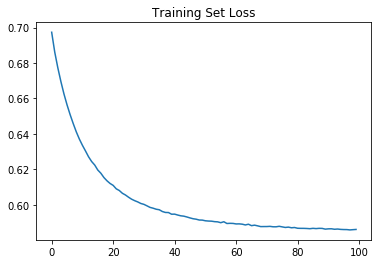

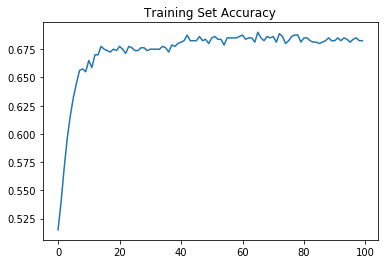

In [10]:
import matplotlib.pyplot as plt

plt.plot(report["train_loss"])
plt.title("Training Set Loss")
plt.show()

plt.plot(report["train_accuracy"])
plt.title("Training Set Accuracy")
plt.show()

#### Validation Set

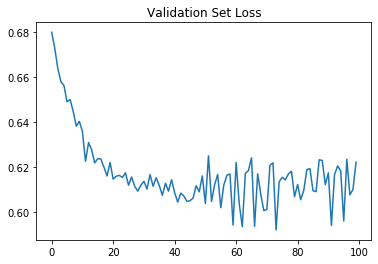

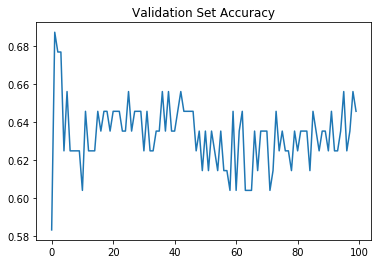

In [11]:
plt.plot(report["validation_loss"])
plt.title("Validation Set Loss")
plt.show()

plt.plot(report["validation_accuracy"])
plt.title("Validation Set Accuracy")
plt.show()